In [7]:
%pip install Levenshtein numpy pandas matplotlib scipy tqdm

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [8]:
import functools
import itertools
import random
import resource
import sys
from collections import deque

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import Levenshtein
from tqdm import tqdm
from time import perf_counter
import heapq


In [4]:
class Node:
    def __init__(self, board, parent):
        self.board = board
        self.parent = parent
        self.cost = 0

    @property
    def empty_pos(self):
        y, x = np.where(self.board == 0)
        x = x.item()
        y = y.item()
        return (y, x)

    @property
    def signature(self):
        flatten_board = list(itertools.chain.from_iterable(self.board))
        list_to_signature = lambda a, b: str(a) + str(b)
        return functools.reduce(list_to_signature, flatten_board)

    @property
    def children(self):
        children = []
        possible_moves = self.__get_possible_moves()
        for move in possible_moves:
            child_board = self.apply_move(move)
            child = Node(child_board, self)
            children.append(child)
        return children

    def __get_possible_moves(self):
        all_moves = [(0, 1), (1, 0), (0, -1), (-1, 0)]
        x, y = self.empty_pos
        possible_moves = []
        for x_delta, y_delta in all_moves:
            new_x = x + x_delta
            new_y = y + y_delta
            if (-1 < new_x < 3) and ((-1 < new_y < 3)):
                move = (new_x, new_y)
                possible_moves.append(move)
        return possible_moves

    def apply_move(self, move):
        new_board = self.board.copy()
        new_board[self.empty_pos], new_board[move] = (
            new_board[move],
            new_board[self.empty_pos],
        )
        return new_board


def generate_random_game() -> np.array:
    board = np.array(np.array_split([1, 2, 3, 4, 5, 6, 7, 8, 0], 3))
    node = Node(board=board, parent=None)

    for _ in range(random.randint(1000, 5000)):
        node = random.choice(node.children)
    node.parent = None
    return node


def print_solution(initial_node: Node, end_node: Node) -> None:
    solution = []
    while end_node.parent:
        solution.append(end_node.board)
        end_node = end_node.parent
    solution = solution[::-1]
    print(initial_node.board)
    print("")
    for board in solution:
        print(board)
        print("")


def get_node_distance_from_parent(end_node):
    i = 0
    while end_node.parent:
        end_node = end_node.parent
        i += 1
    return i


def levenshtein_distance(node: Node) -> int:
    solution_signature = "123456780"
    return Levenshtein.distance(node.signature, solution_signature)


def misplaced_tiles(node: Node) -> int:
    solution_signature = "123456780"

    first_tiles_penalty = 9
    cost = 0
    for i, j in zip(solution_signature, node.signature):
        if i != j:
            cost += 1 + first_tiles_penalty
            first_tiles_penalty -= 1
    return cost


def gradient(node: Node) -> int:
    solution_signature = "123456780"
    cost = 0
    for i, j in zip(solution_signature, node.signature):
        cost += abs(int(i) - int(j))
    return cost


def a_star(initial_node: Node, heuristic: callable) -> Node:
    solution_signature = "123456780"
    visited_nodes = set()

    if initial_node.signature == solution_signature:
        return initial_node

    queue = [(heuristic(initial_node), initial_node)]
    visited_nodes.add(initial_node)

    while len(queue) > 0:
        _, node = heapq.heappop(queue)

        if node.signature == solution_signature:
            return node

        for child_node in node.children:
            if child_node.signature in visited_nodes:
                continue

            child_node.cost = (
                heuristic(child_node) + len(visited_nodes) ** 2.5 + node.cost
            )
            visited_nodes.add(child_node.signature)
            heapq.heappush(queue, (child_node.cost, child_node))
    return node

In [5]:
games = []
pb = tqdm([generate_random_game() for _ in range(100)], leave=True, position=0)
for initial_node in pb:
    pb.set_description(f"Running for {initial_node.signature}")

    t0 = perf_counter()
    end_node = a_star(initial_node, misplaced_tiles)
    delta = perf_counter() - t0 

    games.append(
        {
        "initial_node": initial_node.signature,
        "distance": get_node_distance_from_parent(end_node),
        "time_spent": delta
        }
    )

games = pd.DataFrame(games)

Running for 302147658: 100%|██████████| 100/100 [14:00<00:00,  8.41s/it]


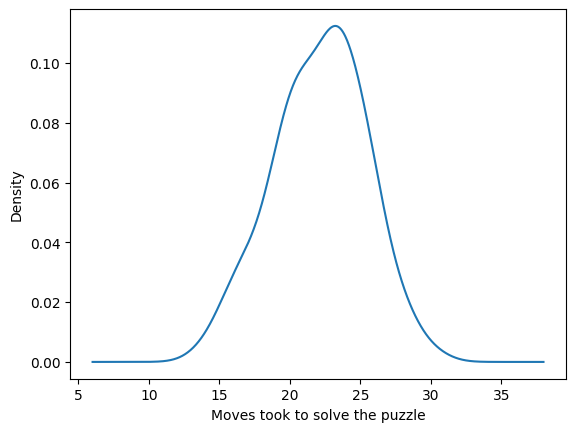

In [14]:
ax = games.distance.plot.kde()

ax.set_xlabel("Moves took to solve the puzzle")
plt.show()

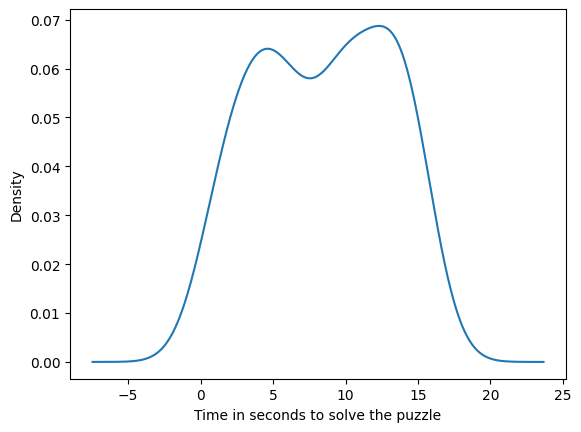

In [15]:
ax = games.time_spent.plot.kde()

ax.set_xlabel("Time in seconds to solve the puzzle")
plt.show()